In [1]:
import tensorflow as tf 
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt 


In [2]:
BATCH_SIZE=32 
IMAGE_SIZE=255
CHANNEL =3 
EPOCHS=20

In [6]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory="Potato",
    seed=123,
    shuffle=True,
    image_size=[IMAGE_SIZE, IMAGE_SIZE], 
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [7]:
len(dataset)

68

In [9]:
class_names =  dataset.class_names

In [12]:
import numpy as np 
for batch_size, label_size in dataset.take(1):
    print("image shape: ", batch_size.shape)
    print("label: ", label_size.numpy)
    print("image: ", batch_size[0])

image shape:  (32, 255, 255, 3)
label:  <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(32,), dtype=int32, numpy=
array([0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1,
       0, 1, 2, 0, 0, 0, 0, 1, 1, 0])>>
image:  tf.Tensor(
[[[162.90582  160.90582  171.90582 ]
  [128.81645  126.81645  137.81645 ]
  [108.07034  106.07034  117.07034 ]
  ...
  [163.0018   161.0018   175.0018  ]
  [158.04297  156.04297  170.04297 ]
  [153.03915  151.03915  165.03915 ]]

 [[148.61253  146.61253  157.61253 ]
  [ 98.383224  96.383224 107.38329 ]
  [144.12883  142.12883  153.1406  ]
  ...
  [158.95512  156.95512  170.95512 ]
  [164.95905  162.95905  176.95905 ]
  [167.97064  165.97064  179.97064 ]]

 [[100.59103   98.59103  109.610634]
  [117.39228  115.39228  126.42354 ]
  [186.45088  184.45088  197.45088 ]
  ...
  [162.981    160.981    174.981   ]
  [163.965    161.965    175.965   ]
  [163.94124  161.94124  175.94124 ]]

 ...

 [[141.92764  137.92764  152.92764 ]
  [120.151

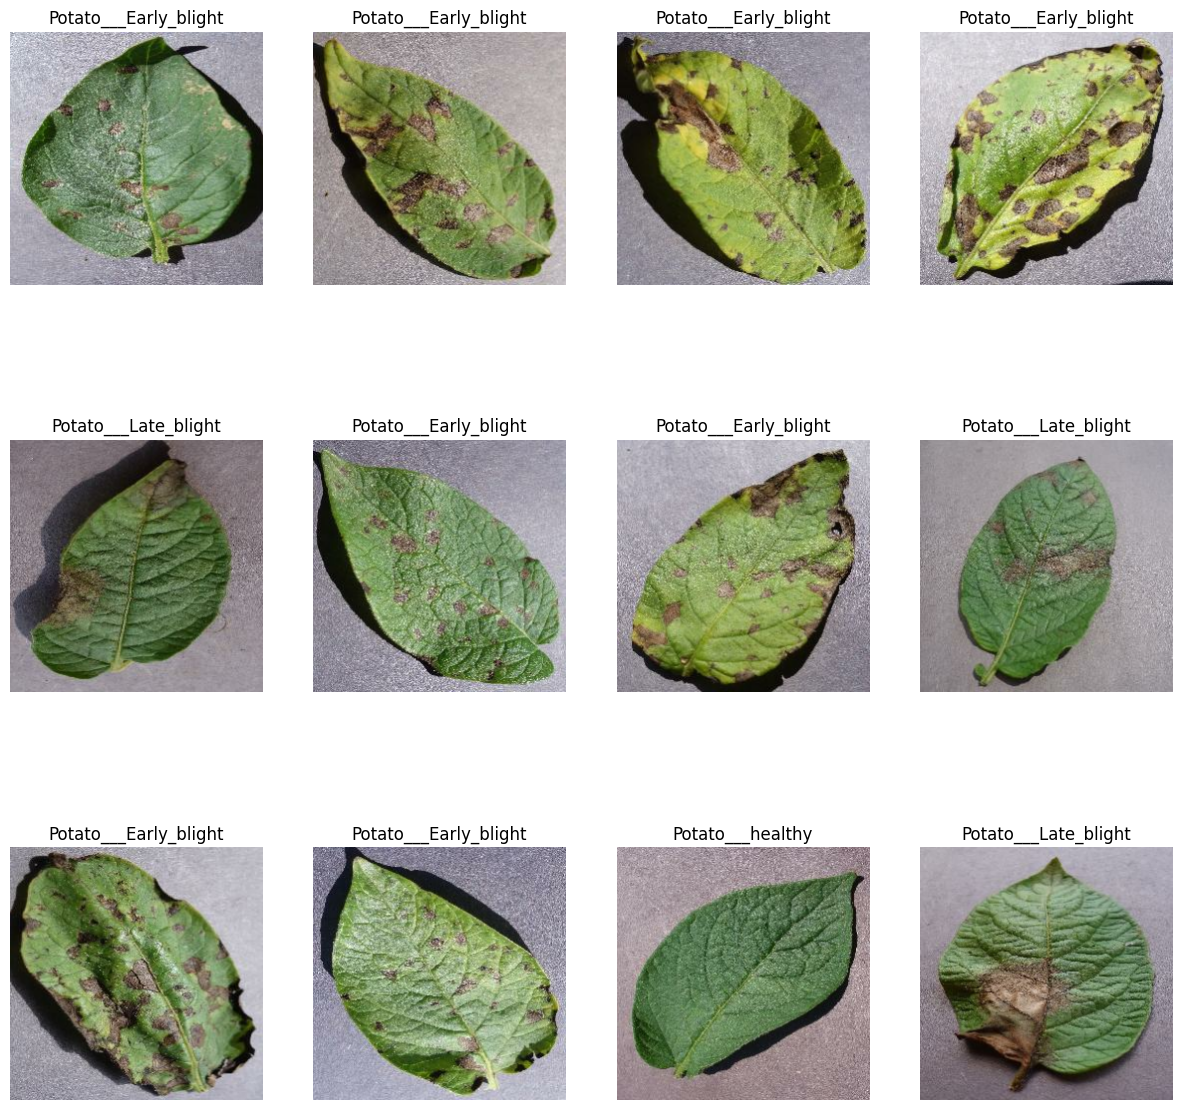

In [14]:
plt.figure(figsize=(15,15))
for img, label in dataset.take(1): 
    for i in range(12): 
        ax = plt.subplot(3,4, i+1)
        plt.imshow(img[i].numpy().astype('uint8'))
        plt.title(class_names[label[i]]) 
        plt.axis('off')
        

In [16]:
# the size after operating image wth kernel is ([i-k]+2p/s)+1 where i is size of nput image(rows, columns) and 
# k is of the kernel 
#stride is by how distance you gotta move the kernel, s is stride in the formula, p is padding done in ordr to minimize losses from the matrix due to striding at the edges 
#now from the obtained feature map you do pooling which is of two types max pooling and average pooling(a 2*2 matrix is used and done) 

In [17]:
# train_size=0.8 
# len(dataset)*0.8

54.400000000000006

In [18]:
# train_ds = dataset.take(54)


In [19]:
# test_ds = dataset.skip(54) 

In [20]:
# len(test_ds)

14

In [21]:
# val_size = 0.1 
# len(dataset)*val_size

6.800000000000001

In [22]:
# val_ds = test_ds.take(6)
# len(val_ds)

6

In [23]:
# test_ds = test_ds.skip(6)

In [24]:
# len(test_ds)

8

In [42]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000): 
    assert (train_split + test_split + val_split) ==1

    ds_size = len(ds) 
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12) 

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size) 
    train_ds = ds.take(train_size) 
    val_ds = ds.skip(train_size).take(val_size) 
    test_ds = ds.skip(train_size).skip(val_size)
    return train_ds, val_ds, test_ds

train_new_ds, val_new_ds, test_new_ds = get_dataset_partitions_tf(dataset)
    
    

In [43]:
len(test_new_ds)

8

In [44]:
len(train_new_ds)

54

In [45]:
len(val_ds)

6

In [46]:
len(dataset)

68

In [47]:
#catching, shuffling and prefetching the data to improve the training performance

In [48]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE) 
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE) 

In [50]:
#resizing and rescaling 

resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1./255)
])

In [53]:
#data augmentation when you have less data 
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [55]:
#applying data augmentation to he train dataset 
train_ds = train_ds.map(lambda x,y: (data_augmentation(x, training=True),y)).prefetch(buffer_size=tf.data.AUTOTUNE)

In [56]:
train_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 255, 255, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [60]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNEL)
n_class =3

model = models.Sequential([
    resize_and_rescale, 
    layers.Conv2D(32, kernel_size=(3,3),activation='relu', input_shape=input_shape),
    layers.MaxPool2D((2,2)), 
    layers.Conv2D(64, kernel_size=(3,3),activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3),activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(32, kernel_size=(3,3),activation='relu', input_shape=input_shape),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(32, kernel_size=(3,3),activation='relu', input_shape=input_shape),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(32, kernel_size=(3,3),activation='relu', input_shape=input_shape),
    layers.MaxPool2D((2,2)),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_class, activation='softmax')
])
model.build(input_shape=input_shape)

In [64]:
model.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [66]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE, 
    validation_data=val_ds,
    verbose=1, 
    epochs=20,
)

Epoch 1/20
8/8 [==============================] - 38s 5s/step - loss: 0.9527 - accuracy: 0.4297 - val_loss: 0.9189 - val_accuracy: 0.5052
Epoch 2/20
8/8 [==============================] - 39s 5s/step - loss: 0.9410 - accuracy: 0.5742 - val_loss: 0.9022 - val_accuracy: 0.5208
Epoch 3/20
8/8 [==============================] - 51s 6s/step - loss: 0.9304 - accuracy: 0.5234 - val_loss: 0.8840 - val_accuracy: 0.4792
Epoch 4/20
8/8 [==============================] - 44s 5s/step - loss: 0.9172 - accuracy: 0.4727 - val_loss: 0.8571 - val_accuracy: 0.6667
Epoch 5/20
8/8 [==============================] - 38s 5s/step - loss: 0.8740 - accuracy: 0.6562 - val_loss: 0.8163 - val_accuracy: 0.6094
Epoch 6/20
8/8 [==============================] - 47s 6s/step - loss: 0.8058 - accuracy: 0.6133 - val_loss: 0.6972 - val_accuracy: 0.7135
Epoch 7/20
8/8 [==============================] - 47s 6s/step - loss: 0.6682 - accuracy: 0.7070 - val_loss: 0.5631 - val_accuracy: 0.7760
Epoch 8/20
8/8 [==================

In [67]:
#saving the model 
model.save('model.h5')

C:\Users\Raghav N\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [68]:
model = tf.keras.models.load_model('model.h5')

1/1 [==============================] - 0s 342ms/step
Actual label is:  Potato___Early_blight
predicted label is:  Potato___Early_blight


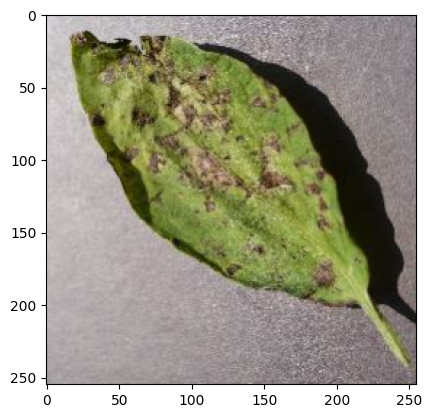

In [78]:
for img, label in test_ds.take(1): 
    first_img=img[0].numpy().astype('uint8') 
    first_label=label[0].numpy().astype('uint8') 
    pred_img = model.predict(img) 
    plt.imshow(first_img)
    print('Actual label is: ', class_names[first_label])
    print("predicted label is: ", class_names[np.argmax(pred_img[0])])

In [79]:
#function to predict more images 

In [88]:
def predict(model,img): 
    img_array =  tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array,0) 
    predictions =  model.predict(img_array) 
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence= round(100* (np.max(predictions[0])),2)
    return predicted_class, confidence 

1/1 [==============================] - 0s 78ms/step


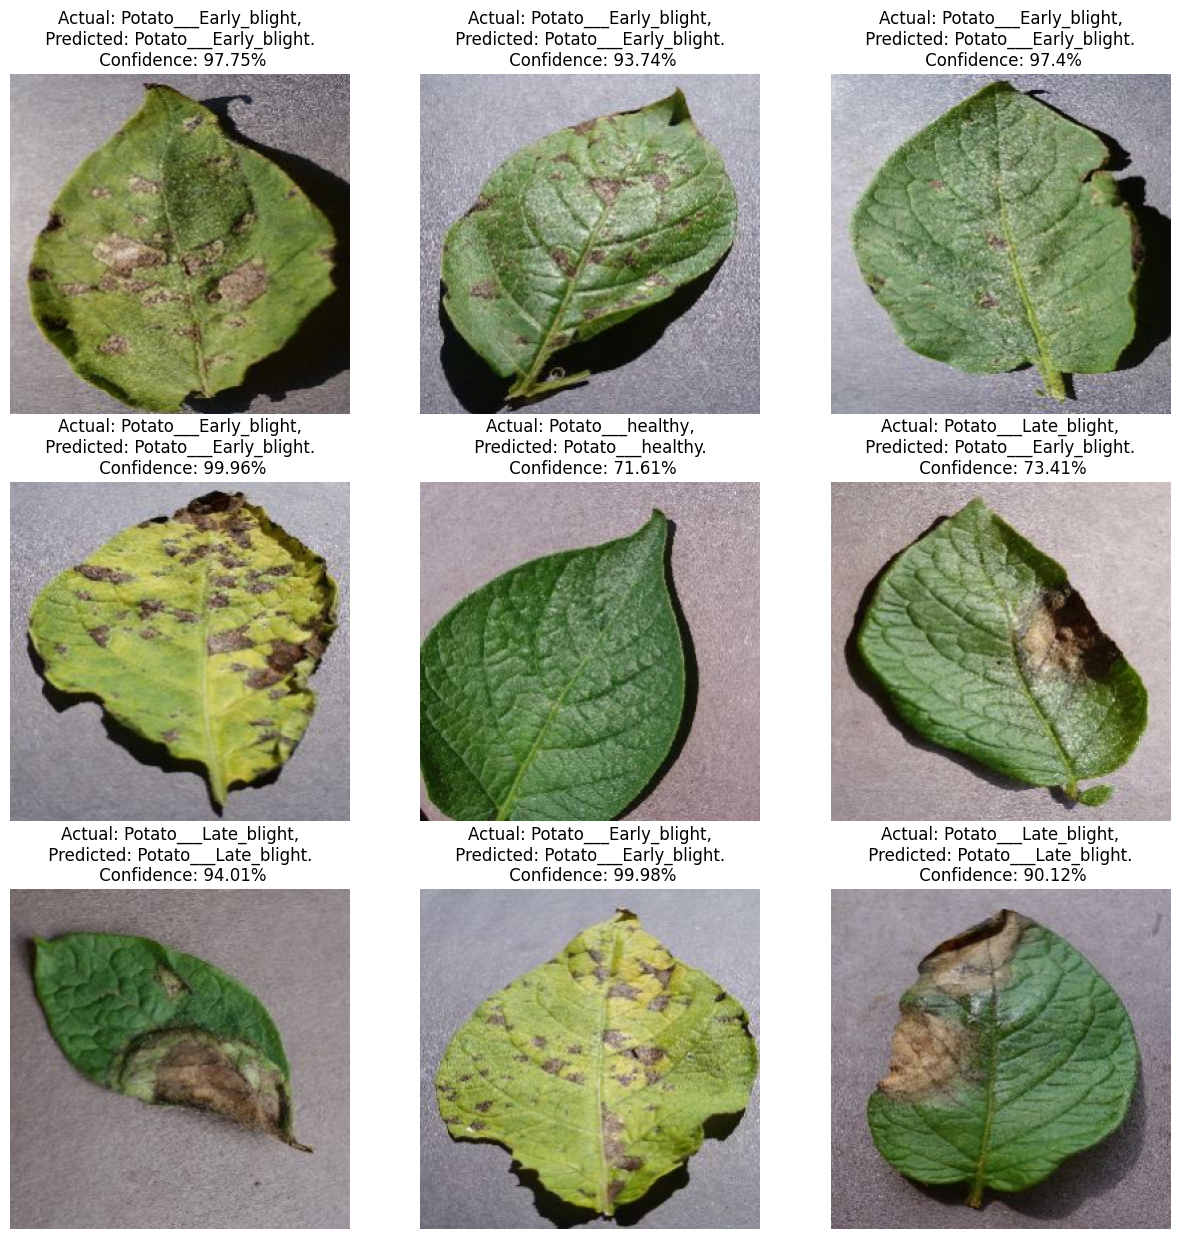

In [89]:
plt.figure(figsize=(15,15))
for images, label in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        predicted_class, confidence = predict(model,images[i].numpy())
        plt.imshow(images[i].numpy().astype('uint8'))
        actual_class = class_names[label[i]]
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}. \n Confidence: {confidence}%")
        plt.axis('off')

In [94]:
import tensorflow 
print(tensorflow.__version__)

2.13.0


In [ ]:
|